In [1]:
# Core Libraries for Data Manipulation and Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine Learning Models and Utilities
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Balancing Datasets
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

# Evaluation Metrics
from sklearn.metrics import classification_report, roc_auc_score

# Creating Pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
df_cleaned = pd.read_csv("../data/processed/credit_default_cleaned.csv")

In [33]:
# Define features
numeric_features = [
    'LIMIT_BAL', 'AGE',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]

categorical_features = [
    'SEX', 'EDUCATION', 'MARRIAGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'
]

In [34]:
X = df_cleaned.drop("DEFAULT", axis=1)
y = df_cleaned["DEFAULT"]

In [36]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Display the shapes of resulting subsets
print(f"Training set X shape: {X_train.shape}")
print(f"Training set y shape: {y_train.shape}")
print(f"Test set X shape: {X_test.shape}")
print(f"Test set y shape: {y_test.shape}")
print("-"*50)
# Verify target variable balance in both sets
print("'DEFAULT' distribution in training set:")
print(y_train.value_counts(normalize=True))
print("-"*50)
print("'DEFAULT' distribution in test set:")
print(y_test.value_counts(normalize=True))

Training set X shape: (24000, 23)
Training set y shape: (24000,)
Test set X shape: (6000, 23)
Test set y shape: (6000,)
--------------------------------------------------
'DEFAULT' distribution in training set:
DEFAULT
0    0.778792
1    0.221208
Name: proportion, dtype: float64
--------------------------------------------------
'DEFAULT' distribution in test set:
DEFAULT
0    0.778833
1    0.221167
Name: proportion, dtype: float64


In [65]:
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

In [37]:
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [38]:
# Preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [40]:
base_models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        tree_method='hist',
        enable_categorical=False
    ),
    "LightGBM": LGBMClassifier(random_state=42)
}

In [41]:
balancing_methods = {
    "No Balancing": None,
    "Random Oversampling": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "Random Undersampling": RandomUnderSampler(random_state=42),
    "Tomek Links": TomekLinks(),
    "SMOTE + Tomek Links": SMOTETomek(random_state=42)
}

In [42]:
def evaluate_model(model, X_test, y_test):
    """Evaluates the model using AUC, Recall, and F1-score."""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return auc, recall, f1

In [43]:
results = []

for balance_name, balancer in balancing_methods.items():
    for model_name, model in base_models.items():
        print(f"Balancing: {balance_name} | Model: {model_name}")

        steps = []
        if balancer is not None:
            steps.append(('balancer', balancer))

        steps.append(('preprocessor', preprocessor))
        steps.append(('classifier', model))

        # Use imblearn Pipeline (supports samplers)
        pipe = ImbPipeline(steps)

        # Train model
        pipe.fit(X_train, y_train)

        # Evaluate
        auc, recall, f1 = evaluate_model(pipe, X_test, y_test)
        results.append((balance_name, model_name, auc, recall, f1))

        print(f"AUC: {auc:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}\n")

Balancing: No Balancing | Model: Random Forest
AUC: 0.7535 | Recall: 0.3587 | F1: 0.4608

Balancing: No Balancing | Model: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:12:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 0.7559 | Recall: 0.3482 | F1: 0.4462

Balancing: No Balancing | Model: LightGBM
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3299
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221208 -> initscore=-1.258639
[LightGBM] [Info] Start training from score -1.258639


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC: 0.7788 | Recall: 0.3662 | F1: 0.4700

Balancing: Random Oversampling | Model: Random Forest
AUC: 0.7560 | Recall: 0.4310 | F1: 0.4989

Balancing: Random Oversampling | Model: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:13:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 0.7504 | Recall: 0.5607 | F1: 0.5058

Balancing: Random Oversampling | Model: LightGBM
[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3321
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC: 0.7748 | Recall: 0.6119 | F1: 0.5363

Balancing: SMOTE | Model: Random Forest
AUC: 0.7397 | Recall: 0.4717 | F1: 0.4893

Balancing: SMOTE | Model: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:14:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 0.7294 | Recall: 0.4544 | F1: 0.4579

Balancing: SMOTE | Model: LightGBM
[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3507
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC: 0.7471 | Recall: 0.4974 | F1: 0.4949

Balancing: Random Undersampling | Model: Random Forest
AUC: 0.7604 | Recall: 0.6225 | F1: 0.5148

Balancing: Random Undersampling | Model: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:14:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 0.7445 | Recall: 0.6338 | F1: 0.4871

Balancing: Random Undersampling | Model: LightGBM
[LightGBM] [Info] Number of positive: 5309, number of negative: 5309
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 10618, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC: 0.7710 | Recall: 0.6315 | F1: 0.5162

Balancing: Tomek Links | Model: Random Forest
AUC: 0.7587 | Recall: 0.3919 | F1: 0.4804

Balancing: Tomek Links | Model: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:15:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 0.7608 | Recall: 0.3843 | F1: 0.4696

Balancing: Tomek Links | Model: LightGBM
[LightGBM] [Info] Number of positive: 5309, number of negative: 17245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3299
[LightGBM] [Info] Number of data points in the train set: 22554, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.235391 -> initscore=-1.178119
[LightGBM] [Info] Start training from score -1.178119


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


AUC: 0.7745 | Recall: 0.3881 | F1: 0.4840

Balancing: SMOTE + Tomek Links | Model: Random Forest
AUC: 0.7434 | Recall: 0.4657 | F1: 0.4860

Balancing: SMOTE + Tomek Links | Model: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:16:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 0.7279 | Recall: 0.4619 | F1: 0.4676

Balancing: SMOTE + Tomek Links | Model: LightGBM
[LightGBM] [Info] Number of positive: 18179, number of negative: 18179
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3507
[LightGBM] [Info] Number of data points in the train set: 36358, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
AUC: 0.7457 | Recall: 0.4959 | F1: 0.4901



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [44]:
results_df = pd.DataFrame(results, columns=['Balancing', 'Model', 'AUC', 'Recall', 'F1'])
results_df = results_df.sort_values(by='Recall', ascending=False).reset_index(drop=True)

print(results_df)

               Balancing          Model       AUC    Recall        F1
0   Random Undersampling        XGBoost  0.744495  0.633760  0.487113
1   Random Undersampling       LightGBM  0.771046  0.631500  0.516169
2   Random Undersampling  Random Forest  0.760358  0.622457  0.514802
3    Random Oversampling       LightGBM  0.774797  0.611907  0.536328
4    Random Oversampling        XGBoost  0.750413  0.560663  0.505778
5                  SMOTE       LightGBM  0.747108  0.497362  0.494938
6    SMOTE + Tomek Links       LightGBM  0.745731  0.495855  0.490130
7                  SMOTE  Random Forest  0.739687  0.471741  0.489254
8    SMOTE + Tomek Links  Random Forest  0.743380  0.465712  0.486040
9    SMOTE + Tomek Links        XGBoost  0.727921  0.461944  0.467582
10                 SMOTE        XGBoost  0.729387  0.454408  0.457859
11   Random Oversampling  Random Forest  0.756016  0.431047  0.498910
12           Tomek Links  Random Forest  0.758675  0.391861  0.480370
13           Tomek L

In [45]:
results_df.to_csv("model_balancing_results.csv", index=False)

### Performing hyperparameter tuning for LightGBM model with Random Undersampling as it has high Recall value and AUC score.

In [52]:
balancer = RandomUnderSampler(random_state=42)
lgbm = LGBMClassifier(random_state=42, class_weight=None)

In [47]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [5, 7, 9],
    'classifier__num_leaves': [15, 31],
    'classifier__subsample': [0.8, 1.0]
}

In [53]:
pipe = ImbPipeline(steps=[
    ('balancer', balancer),
    ('preprocessor', preprocessor),
    ('classifier', lgbm)
])

In [60]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 7],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__num_leaves': [31, 50, 100],
}

In [61]:
scoring = {'AUC': 'roc_auc', 'Recall': 'recall'}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit='Recall',
    cv=4,
    n_jobs=-1,
    verbose=2
)

In [62]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[LightGBM] [Info] Number of positive: 5309, number of negative: 5309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 10618, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('balancer',
                                        RandomUnderSampler(random_state=42)),
                                       ('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['LIMIT_BAL',
                                                                          'AGE',
                                                                          'BILL_AMT1',
                                                                          'BILL_AMT2',
                                                                          'BILL_AMT3',
                                                                          'BILL_AMT4',
                                                                          'BILL_AMT5',
                                                                          'BILL_AMT6',
                                                                          'PAY_AMT1',
                                                                          'PAY_AMT2',
                                                                          'PAY_AMT3',
                                                                          'PAY_AMT4',
                                                                          'PAY_AMT5',
                                                                          'PAY_AMT6']),
                                                                        ('cat',
                                                                         OneHotEncoder(handl...
                                                                          'EDUCATION',
                                                                          'MARRIAGE',
                                                                          'PAY_0',
                                                                          'PAY_2',
                                                                          'PAY_3',
                                                                          'PAY_4',
                                                                          'PAY_5',
                                                                          'PAY_6'])])),
                                       ('classifier',
                                        LGBMClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.05, 0.1],
                         'classifier__max_depth': [5, 7],
                         'classifier__n_estimators': [100, 200],
                         'classifier__num_leaves': [31, 50, 100]},
             refit='Recall', scoring={'AUC': 'roc_auc', 'Recall': 'recall'},
             verbose=2)

In [64]:
print("Cross-validation results summary:")
cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results[['mean_test_AUC', 'mean_test_Recall', 'params']].sort_values(by='mean_test_Recall', ascending=False).head(10))

Cross-validation results summary:
    mean_test_AUC  mean_test_Recall  \
21       0.771721          0.660389   
22       0.768514          0.656245   
23       0.767948          0.654362   
18       0.778219          0.653418   
15       0.774438          0.652852   
11       0.776829          0.652664   
10       0.777075          0.652287   
16       0.773782          0.650591   
17       0.773782          0.650591   
9        0.778569          0.650216   

                                               params  
21  {'classifier__learning_rate': 0.1, 'classifier...  
22  {'classifier__learning_rate': 0.1, 'classifier...  
23  {'classifier__learning_rate': 0.1, 'classifier...  
18  {'classifier__learning_rate': 0.1, 'classifier...  
15  {'classifier__learning_rate': 0.1, 'classifier...  
11  {'classifier__learning_rate': 0.05, 'classifie...  
10  {'classifier__learning_rate': 0.05, 'classifie...  
16  {'classifier__learning_rate': 0.1, 'classifier...  
17  {'classifier__learning_rate'

In [63]:
print("Best Parameters Found:")
print(grid_search.best_params_)

print("\nBest AUC Score During CV:")
print(grid_search.best_score_)

# Evaluate on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Core Metrics
auc = roc_auc_score(y_test, y_pred_proba)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print key metrics
print(f"\nTest Set Performance:")
print(f"\nAUC: {auc:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

# Detailed evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
print("Confusion Matrix:")
print(cm_df)

Best Parameters Found:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__num_leaves': 31}

Best AUC Score During CV:
0.66038915458367

Test Set Performance:

AUC: 0.7592 | Recall: 0.6375 | F1: 0.5025

Classification Report:
              precision    recall  f1-score   support

           0     0.8785    0.7445    0.8060      4673
           1     0.4147    0.6375    0.5025      1327

    accuracy                         0.7208      6000
   macro avg     0.6466    0.6910    0.6543      6000
weighted avg     0.7760    0.7208    0.7389      6000

Confusion Matrix:
          Pred 0  Pred 1
Actual 0    3479    1194
Actual 1     481     846


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


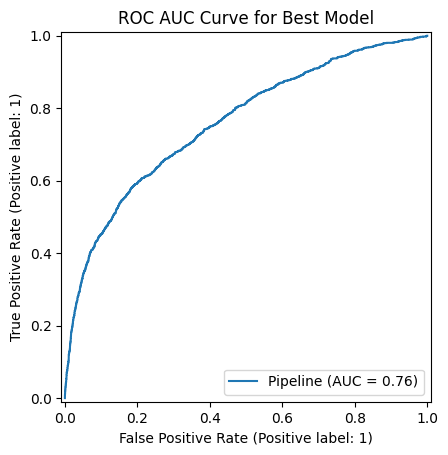

In [70]:
# Plot ROC AUC curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title('ROC AUC Curve for Best Model')
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


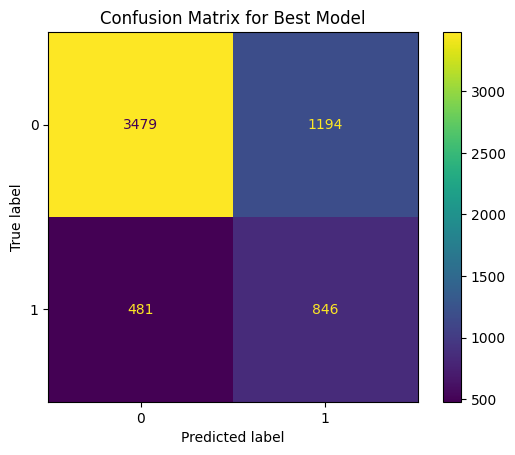

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Confusion Matrix for Best Model')
plt.show()

In [68]:
import joblib
joblib.dump(best_model, "best_model.pkl")

['best_model.pkl']